In [1]:
# Part 0: general imports
from os import path
import csv
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

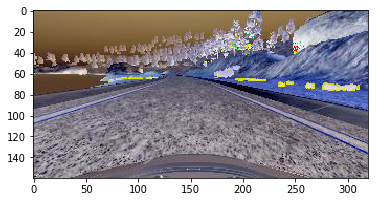

In [2]:
# Part 1: show a frame 
img = cv2.imread(glob.glob('data/IMG/center_*')[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(np.array(img, dtype=np.float32))
plt.show()

In [3]:
# Part 2: load data for X and y
with open('data/driving_log.csv') as f_csv:
    telemetry = [l for l in csv.reader(f_csv)]

telemetry = telemetry[1:]
    
center_im_idx =      0
steering_angle_idx = 3

train_samples, validation_samples = train_test_split(telemetry, test_size=0.2)

def read_image_rgb(impath):
    _, filename = path.split(impath)
    tmp = cv2.imread('data/IMG/{}'.format(filename))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    return np.array(tmp)

def generator(samples, batch_size=32):
    nb_samples = len(samples)
    while 1:
        samples = shuffle(samples)
        for offset in range(0, nb_samples, batch_size):
            batch = samples[offset:offset+batch_size]
            batch_x_tmp = []
            batch_y_tmp = []
            for sample in batch:
                batch_x_tmp.append(read_image_rgb(sample[center_im_idx]))
                batch_y_tmp.append(sample[steering_angle_idx])
            yield (np.array(batch_x_tmp, dtype=np.float32), np.array(batch_y_tmp, dtype=np.float32))

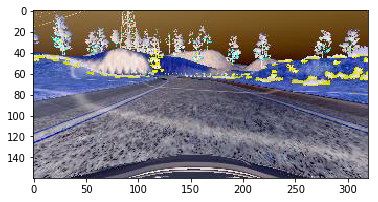

-0.00111607


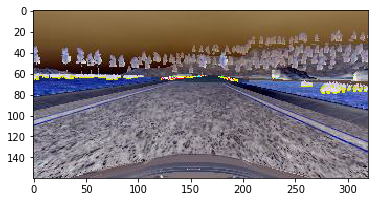

-0.121241


In [4]:
# Test generator and read_image_rgb
test_gen_data = train_samples[0:2]
test_gen = generator(test_gen_data, batch_size=1)
for i in range(2):
    x_data, y_data = next(test_gen)
    plt.imshow(x_data[0])
    plt.show()
    print(y_data[0])

Using TensorFlow backend.


Epoch 1/5
9994/9994 [==============================] - 148s - loss: 0.0577 - val_loss: 0.0288

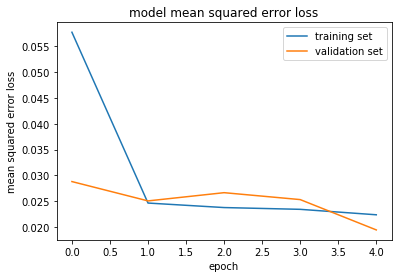

In [5]:
# Part 3: train the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Dropout, Activation
from keras.layers.convolutional import Cropping2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Conv2D(32, 3, 3))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(Conv2D(64, 3, 3))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(Conv2D(128, 3, 3))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(1))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(optimizer='adam', loss='mse')
history_object = model.fit_generator(train_generator,
                                     samples_per_epoch=len(train_samples),
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=5, 
                                     verbose=True,
                                     validation_data=validation_generator)
model.save('model/model.h5')

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()